# Notes on Chapter 2 of Statistical Rethinking 2nd Edition by Richard McElreath

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from math import pi
tfd = tfp.distributions
tfm = tf.math

In [2]:
%load_ext rpy2.ipython

### 2.1

In [3]:
%%R

ways <- c(0, 3, 8, 9, 0)
ways/sum(ways)

[1] 0.00 0.15 0.40 0.45 0.00


In [4]:
ways = tf.constant([0, 3, 8, 9, 0])
ways/tfm.reduce_sum(ways)

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.  , 0.15, 0.4 , 0.45, 0.  ])>

### 2.2

In [5]:
%%R

dbinom(6, size=9, prob=0.5)

[1] 0.1640625


In [6]:
float(tfd.Binomial(total_count=9, probs=0.5).prob(6))

0.16406261920928955

### 2.3

In [7]:
%%R

p_grid <- seq(from=0, to=1, length.out=20)
prior <- rep(1, 20)
likelyhood <- dbinom(6, size=9, prob=p_grid)
unstd.posterior <- likelyhood * prior
posterior <- unstd.posterior/ sum(unstd.posterior)

In [8]:
p_grid = tf.linspace(0., 1, 20)
prior = tf.ones_like(p_grid)
likelyhood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)
unnormalized_posterior = likelyhood * prior
posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)

### 2.4

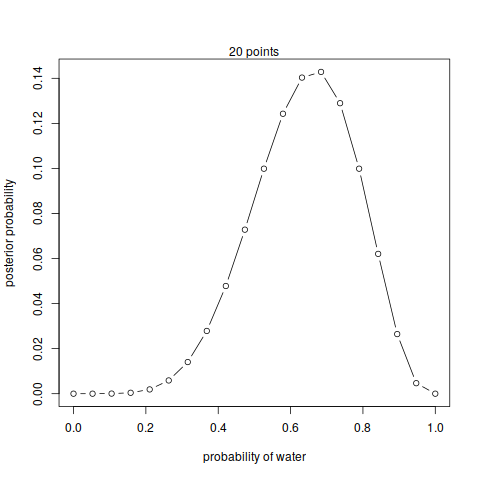

In [9]:
%%R

plot(p_grid, posterior, type="b", xlab="probability of water", ylab="posterior probability")
mtext("20 points")

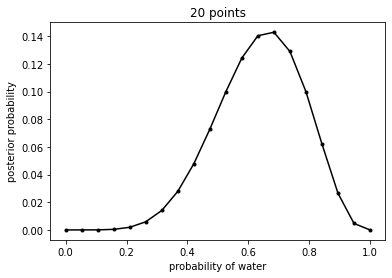

In [10]:
plt.plot(p_grid, posterior, "k.-")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f'{len(p_grid)} points');

### 2.5


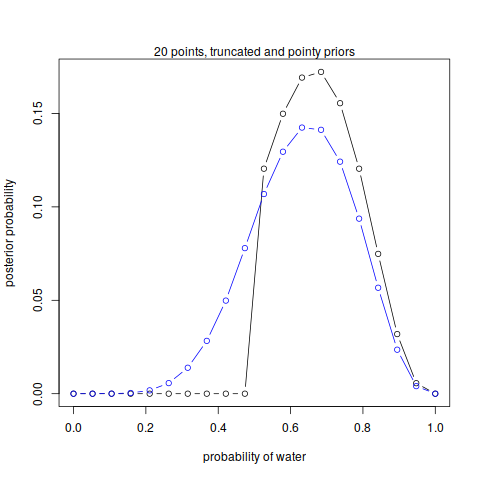

In [11]:
%%R

p_grid <- seq(from=0, to=1, length.out=20)

prior <- ifelse(p_grid < 0.5, 0, 1)
likelyhood <- dbinom(6, size=9, prob=p_grid)
unstd.posterior <- likelyhood * prior
posterior <- unstd.posterior/ sum(unstd.posterior)
plot(p_grid, posterior, type="b", xlab="probability of water", ylab="posterior probability")

prior <- exp(-0.5*abs(p_grid - 0.5))
likelyhood <- dbinom(6, size=9, prob=p_grid)
unstd.posterior <- likelyhood * prior
posterior <- unstd.posterior/ sum(unstd.posterior)
lines(p_grid, posterior, type="b", col="blue")

mtext("20 points, truncated and pointy priors")

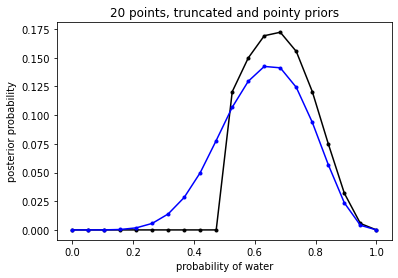

In [12]:
p_grid = tf.linspace(0., 1, 20)

prior = tf.where(p_grid < 0.5, tf.zeros_like(p_grid), tf.ones_like(p_grid))
likelyhood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)
unnormalized_posterior = likelyhood * prior
posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)
plt.plot(p_grid, posterior, ".-k")

prior = tfm.exp(-0.5*tfm.abs(p_grid - 0.5))
likelyhood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)
unnormalized_posterior = likelyhood * prior
posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)
plt.plot(p_grid, posterior, ".-b")

plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f'{len(p_grid)} points, truncated and pointy priors');

### 2.6

In [13]:
%%R

library(rethinking)
globe.qa <- quap(
    alist(
        W ~ dbinom(W+L, p),
        p ~ dunif(0, 1)
    ),
    data=list(W=6, L=3)
)

precis(globe.qa)

R[write to console]: Loading required package: rstan

R[write to console]: Loading required package: StanHeaders

R[write to console]: Loading required package: ggplot2

R[write to console]: RStudio Community is a great place to get help:
https://community.rstudio.com/c/tidyverse

R[write to console]: rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

R[write to console]: For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: dagitty

R[write to console]: rethinking (Version 2.01)

R[write to console]: 
Attaching package: ‘rethinking’


R[write to console]: The following object is masked from ‘package:stats’:

    rstudent




  mean   sd 5.5% 94.5%
p 0.67 0.16 0.42  0.92


I don't see an equivalent of the author's library for tensorflow probability, so we'll need to implement the quadratic approximation by hand...

In [14]:
W = tf.constant(6.)
L = tf.constant(3.)

def likelihood(p):
    N = W + L
    return tfd.Binomial(N, probs=p).prob(W) * tfd.Uniform().prob(p)

# Tensorflow gives a lot of warnings that don't have workarounds to avoid the warning; thus we need to disable them manually
def NestedGradientWarningFilter(record):
    return not record.getMessage().startswith('Calling GradientTape.gradient on a persistent tape inside its context')

# find the point of maximum likelihood
mu = tf.Variable(0.5, 'mu')
optimizer = tf.keras.optimizers.Adam(0.1)
for i in range(100):
    with tf.GradientTape() as tape:
        loss = tfm.negative(tfm.log(likelihood(mu)))
    gradients = tape.gradient(loss, [mu])
    optimizer.apply_gradients(zip(gradients, [mu]))
    
# find the Hessian at that point
with tf.GradientTape(persistent=True) as tape:
    loss = tfm.negative(tfm.log(likelihood(mu)))
    tf.get_logger().addFilter(NestedGradientWarningFilter)
    gradients = tape.gradient(loss, [mu])
    tf.get_logger().removeFilter(NestedGradientWarningFilter)
hessians = tape.jacobian(gradients[0], mu)

sigma = tfm.sqrt(1/hessians)

print("  mean   sd 5.5% 94.5%")
print(f'p {float(mu):.2f} {float(sigma):.2f} {float(mu - 1.6*sigma):.2f}  {float(mu + 1.6*sigma):.2f}')

  mean   sd 5.5% 94.5%
p 0.67 0.16 0.42  0.92


### 2.7

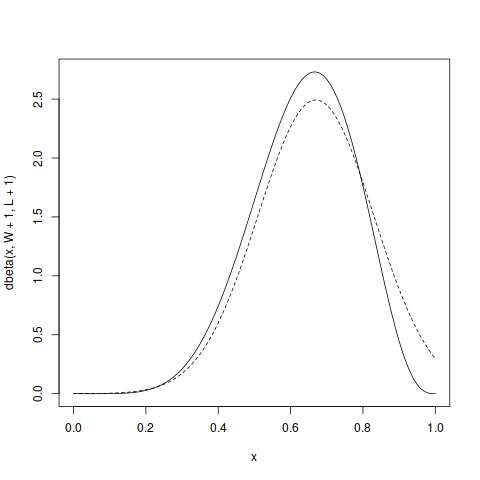

In [15]:
%%R

W <- 6
L <- 3
curve(dbeta(x, W+1, L+1), from=0, to=1)
curve(dnorm(x, 0.67, 0.16), lty=2, add=TRUE)

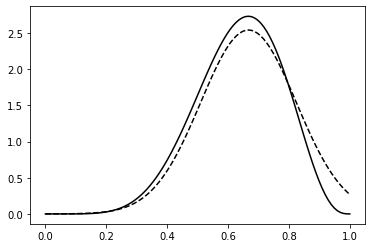

In [16]:
W = 6.
L = 3.
x = tf.linspace(0., 1., 100)
plt.plot(x, tfd.Beta(W + 1, L + 1).prob(x), 'k-')
plt.plot(x, tfd.Normal(mu, sigma).prob(x), 'k--');

### 2.8

In [17]:
%%R

n_samples <- 1000
p <- rep(NA, n_samples)
p[1] <- 0.5
W <- 6
L <- 3
for (i in 2:n_samples) {
    p_new <- rnorm(1, p[i-1], 0.1)
    if (p_new < 0) p_new <- abs(p_new) # reflecting boundaries
    if (p_new > 1) p_new <- 2 - p_new
    q0 <- dbinom(W, W+L, p[i-1])
    q1 <- dbinom(W, W+L, p_new)
    p[i] <- ifelse(runif(1) < q1/q0, p_new, p[i-1])
}

In [18]:
n_samples = 1000
p = [tf.constant(0.5)]
W = 6
L = 3
for i in range(1,n_samples):
    p_new = tfd.Normal(p[-1], 0.1).sample()
    p_new = tfm.abs(p_new)
    p_new = tfm.minimum(p_new, 2 - p_new)
    qprev = tfd.Binomial(W + L, probs=p[-1]).prob(W)
    qnew = tfd.Binomial(W + L, probs=p_new).prob(W)
    p.append(tf.where(tfd.Uniform().sample(p[-1].shape) < qnew/qprev, p_new, p[-1]))

### 2.9

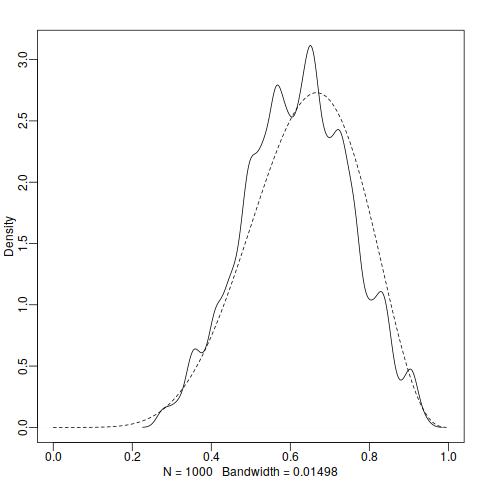

In [19]:
%%R

dens(p, xlim=c(0,1))
curve(dbeta(x, W+1, L+1), lty=2, add=TRUE)

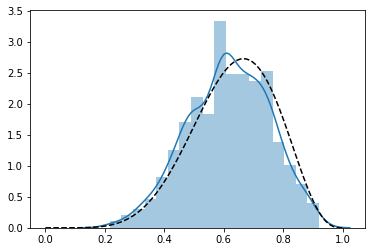

In [20]:
import seaborn as sns
sns.distplot(p)
x = tf.linspace(0.,1,100)
plt.plot(x, tfd.Beta(W+1, L+1).prob(x), '--k')

### Extension of 2.8-2.9 with vectorized tensorflow code

The advantage of using tensorflow is that we can calculate many trajectories in parallel on one or more GPUs.  This code will calculate one billion samples from the posterior in less than 1 second on a consumer video card from 2018 (Nvidia 2080 Ti):

In [21]:
# combine the entire step into a function to keep the data on the GPU
@tf.function()
def metropolis_step(p_old, W, L):
    p_new = tfd.Normal(p_old, 0.1).sample()
    p_new = tfm.abs(p_new)
    p_new = tfm.minimum(p_new, 2 - p_new)
    qprev = tfd.Binomial(W + L, probs=p_old).prob(W)
    qnew = tfd.Binomial(W + L, probs=p_new).prob(W)
    return tf.where(tfd.Uniform().sample(p_old.shape) < qnew/qprev,
                    p_new, p_old)

n_samples = 100
n_replicates = 10000000
runin = 20
p = [0.5*tf.ones(n_replicates)]
W = 6
L = 3

for i in range(1,n_samples + runin):
    p.append(metropolis_step(p[-1], W, L))
    
p = tf.concat(p[runin:], 0)

Because we aren't using parallel code to plot, we'll just plot the first million samples.

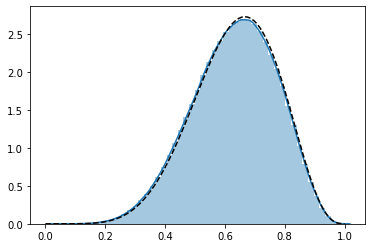

In [22]:
sns.distplot(p[:1000000])
x = tf.linspace(0.,1,100)
plt.plot(x, tfd.Beta(W+1, L+1).prob(x), '--k');

Here's a slightly messier example which uses 16 bit floating point (for speed/memory efficiency) and uses the real (uniform) prior for p.

In [23]:
# combine the entire step into a function to keep the data on the GPU
@tf.function()
def metropolis_step(p_old, W, L):
    zero_f16 = tf.constant(0., dtype=tf.float16)
    one_f16 = tf.constant(1., dtype=tf.float16)
    step_sd = tf.constant(0.1, dtype=tf.float16)
    p_new = tfd.Normal(p_old, step_sd).sample()
    p_new = tfm.abs(p_new)
    p_new = tfm.minimum(p_new, 2 - p_new)
    qprev = tfd.Binomial(W + L, probs=p_old).prob(W)
    qnew = tfd.Binomial(W + L, probs=p_new).prob(W)
    return tf.where(
        tfd.Uniform(zero_f16, one_f16).sample(p_old.shape) < qnew/qprev,
        p_new,
        p_old)

n_samples = 100
n_replicates = 10000000
runin = 100
p = [tfd.Uniform(tf.constant(0., dtype=tf.float16), tf.constant(1., dtype=tf.float16)).sample(n_replicates)]
W = 6
L = 3

for i in range(1,n_samples + runin):
    p.append(metropolis_step(p[-1], W, L))
    
p = tf.concat(p[runin:], 0)

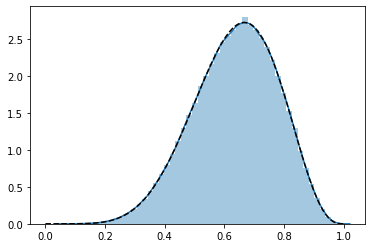

In [24]:
import seaborn as sns
sns.distplot(p[:1000000])
x = tf.linspace(0.,1,100)
plt.plot(x, tfd.Beta(W+1, L+1).prob(x), '--k');

## Practice

### 2E1

2

### 2E2

3

### 2E3

1

### 2E4

Although in principle whether my finger lands on water is a deterministic process, my lack of knowledge of the details of the process leaves me with enough uncertainty that mutiple outcomes from the process seem credible.  If forced to quantify the degree of credibility of my finger landing on water, I might imagine assigning a weighted sum of credibility (based on both intuition and prior observations) across all models of the events of the globe tossing I can imagine. Then 70 percent of that credibility belongs to models of future events where my finger ends on on water.

### 2M1

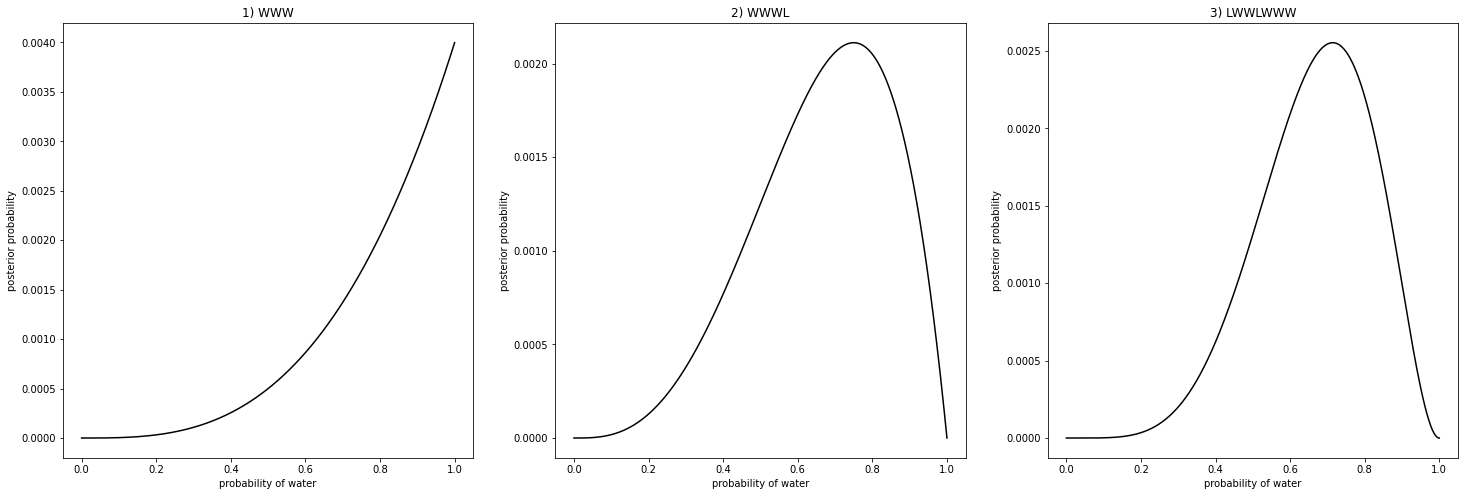

In [25]:
def plot_posteriors(ax, total_count, water_count, title, num_points=1000, prior=tf.ones_like):
    p_grid = tf.linspace(0., 1., num_points)
    prior_grid = prior(p_grid)
    likelyhood = tfd.Binomial(total_count=total_count, probs=p_grid).prob(water_count)
    unnormalized_posterior = likelyhood * prior_grid
    posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)
    ax.plot(p_grid, posterior, "-k")
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    ax.set_title(title);

fig, axs = plt.subplots(1, 3, figsize=(25,8))
plot_posteriors(axs[0], 3, 3, "1) WWW")
plot_posteriors(axs[1], 4, 3, "2) WWWL")
plot_posteriors(axs[2], 7, 5, "3) LWWLWWW")

### 2M2

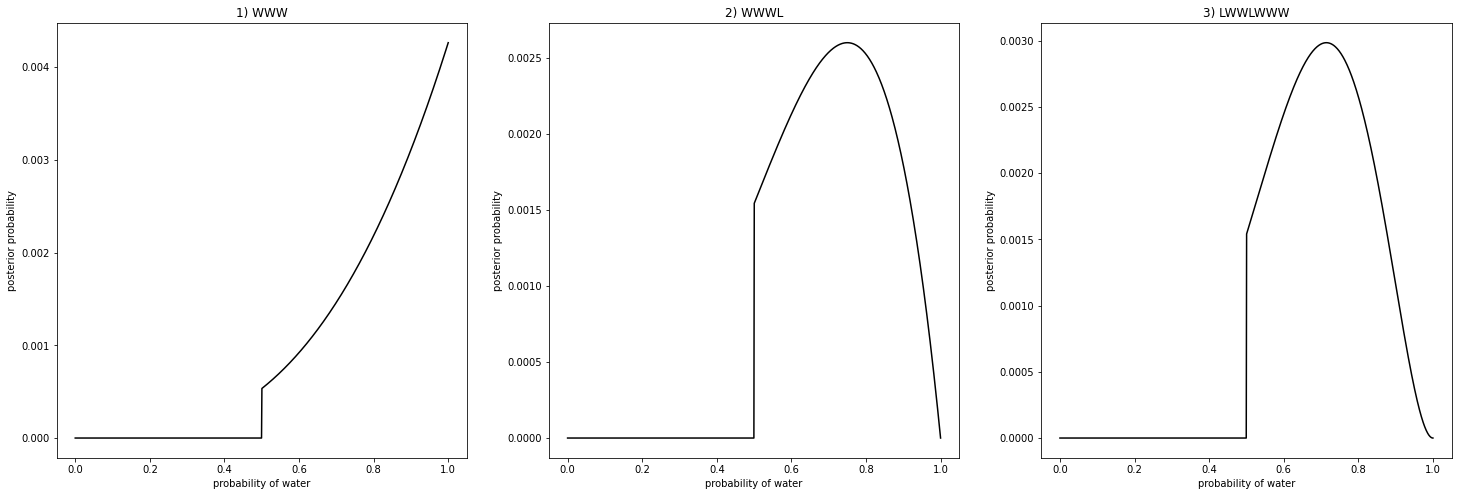

In [26]:
prior = lambda p : tf.where(p < 0.5, tf.zeros_like(p), tf.ones_like(p))

fig, axs = plt.subplots(1, 3, figsize=(25,8))
plot_posteriors(axs[0], 3, 3, "1) WWW", prior=prior)
plot_posteriors(axs[1], 4, 3, "2) WWWL", prior=prior)
plot_posteriors(axs[2], 7, 5, "3) LWWLWWW", prior=prior)

### 2M3

$$ 
\begin{align}
\mathrm{Pr}(\mathrm{Earth} | \mathrm{land})
    &= \frac{\mathrm{Pr}(\mathrm{land} | \mathrm{Earth}) \mathrm{Pr}(\mathrm{Earth})}{
        \mathrm{Pr}(\mathrm{land})} \\
    &= \frac{\mathrm{Pr}(\mathrm{land} | \mathrm{Earth}) \mathrm{Pr}(\mathrm{Earth})}{
        \mathrm{Pr}(\mathrm{land} | \mathrm{Earth}) \mathrm{Pr}(\mathrm{Earth}) +
        \mathrm{Pr}(\mathrm{land} | \mathrm{Mars}) \mathrm{Pr}(\mathrm{Mars})
        } \\
    &= \frac{\mathrm{Pr}(\mathrm{land} | \mathrm{Earth}) \mathrm{Pr}(\mathrm{Earth})}{
        \mathrm{Pr}(\mathrm{land} | \mathrm{Earth}) \mathrm{Pr}(\mathrm{Earth}) +
        \mathrm{Pr}(\mathrm{land} | \mathrm{Mars}) \mathrm{Pr}(\mathrm{Mars})
        } \\
    &= \frac{(1 - 0.7) \cdot (0.5)}{
        (1 - 0.7) \cdot (0.5) +
        (1) \cdot (0.5)
        } \\
    &= \frac{3}{13} \\
    &\approx 0.23
\end{align}
$$


In [27]:
# simulation

n_trials = 1000000
earth = tfd.Binomial(1, probs=0.5).sample(n_trials)
land = tf.where(earth == 1., tfd.Binomial(1, probs= 0.3).sample(n_trials), tf.ones(n_trials))
earth_given_land = tf.boolean_mask(earth, land == 1)
print(f'{tfm.reduce_mean(earth_given_land):.3}')

0.231


### 2M4

| Card | Side 1 | Side 2 |
|------|--------|--------|
|    0 | Black  | Black  |
|    0 | Black  | White  |
|    0 | White  | White  |

We assume we are equally likely to be viewing any of the three black sides of a card in the deck.  We can see that two out of those three black sides have a black side on the opposite side of the card, so the probability that the other side is black is 2/3.

In [28]:
# simulation

n_trials = 1000000
sides_black = tf.constant([[1,1], [1,0], [0,0]])
num_cards = sides_black.shape[0]
first_cards = tf.random.categorical([tf.ones(num_cards)], n_trials)[0]
first_top_sides = tf.random.categorical([tf.ones(2)], n_trials)[0]
first_sides_black = tf.gather(sides_black, first_cards)
first_top_sides_black = tf.where(first_top_sides == 0, first_sides_black[:,0], first_sides_black[:,1])
first_bottom_sides_black = tf.where(first_top_sides == 1, first_sides_black[:,0], first_sides_black[:,1])
first_bottom_sides_black_given_top_sides_black = tf.boolean_mask(first_bottom_sides_black, first_top_sides_black == 1)
print(f'{tfm.reduce_mean(tf.cast(first_bottom_sides_black_given_top_sides_black, tf.float32)):.3}')

0.666


### 2M5

Given 4 of the 5 black sides in the new deck are paired with a black side on the opposite side, the probability is 4/5.

In [29]:
# simulation

n_trials = 1000000
sides_black = tf.constant([[1,1], [1,0], [0,0], [1,1]])
num_cards = sides_black.shape[0]
first_cards = tf.random.categorical([tf.ones(num_cards)], n_trials)[0]
first_top_sides = tf.random.categorical([tf.ones(2)], n_trials)[0]
first_sides_black = tf.gather(sides_black, first_cards)
first_top_sides_black = tf.where(first_top_sides == 0, first_sides_black[:,0], first_sides_black[:,1])
first_bottom_sides_black = tf.where(first_top_sides == 1, first_sides_black[:,0], first_sides_black[:,1])
first_bottom_sides_black_given_top_sides_black = tf.boolean_mask(first_bottom_sides_black, first_top_sides_black == 1)
print(f'{tfm.reduce_mean(tf.cast(first_bottom_sides_black_given_top_sides_black, tf.float32)):.3}')

0.8


### 2M6

With the new arrangement we have 1 way to pull the single B/B card from the deck (accounting for 2 ways to see a black side) and 2 ways to pull the single B/W card from the bag (accounting for 2 ways to see a black side); thus the probability is 2/4 = 1/2.

In [30]:
# simulation

n_trials = 1000000
sides_black = tf.constant([[1,1], [1,0], [0,0]])
num_cards = sides_black.shape[0]
first_cards = tf.random.categorical(tfm.log([[1.,2.,3.]]), n_trials)[0]
first_top_sides = tf.random.categorical([tf.ones(2)], n_trials)[0]
first_sides_black = tf.gather(sides_black, first_cards)
first_top_sides_black = tf.where(first_top_sides == 0, first_sides_black[:,0], first_sides_black[:,1])
first_bottom_sides_black = tf.where(first_top_sides == 1, first_sides_black[:,0], first_sides_black[:,1])
first_bottom_sides_black_given_top_sides_black = tf.boolean_mask(first_bottom_sides_black, first_top_sides_black == 1)
print(f'{tfm.reduce_mean(tf.cast(first_bottom_sides_black_given_top_sides_black, tf.float32)):.3}')

0.5


### 2M7

Our possible draws are 2 $\times$ BB+BW (one for each face of BB), 2 $\times$ 2 $\times$ BB+WW (one for each face of each card), and 2 $\times$ BW+WW (one for each face of WW).  Thus the probability is 6/8, or 0.75.

In [31]:
# simulation

n_trials = 1000000
sides_black = tf.constant([[1,1], [1,0], [0,0]])
num_cards = sides_black.shape[0]
first_cards = tf.random.categorical([tf.ones(num_cards)], n_trials)[0]
first_top_sides = tf.random.categorical([tf.ones(2)], n_trials)[0]
first_sides_black = tf.gather(sides_black, first_cards)
first_top_sides_black = tf.where(first_top_sides == 0, first_sides_black[:,0], first_sides_black[:,1])
first_bottom_sides_black = tf.where(first_top_sides == 1, first_sides_black[:,0], first_sides_black[:,1])
second_cards_post_draw1 = tf.random.categorical([tf.ones(num_cards-1)], n_trials)[0]
second_cards = tf.where(second_cards_post_draw1 >= first_cards, second_cards_post_draw1 + 1, second_cards_post_draw1)
second_top_sides = tf.random.categorical([tf.ones(2)], n_trials)[0]
second_sides_black = tf.gather(sides_black, second_cards)
second_top_sides_black = tf.where(second_top_sides == 0, second_sides_black[:,0], second_sides_black[:,1])

first_bottom_sides_black_given_top_sides_black_white = tf.boolean_mask(
    first_bottom_sides_black, tf.logical_and(first_top_sides_black == 1, second_top_sides_black == 0))
print(f'{tfm.reduce_mean(tf.cast(first_bottom_sides_black_given_top_sides_black_white, tf.float32)):.3}')

0.751


### 2H1

Let $A$ and $\neg A$ represent the Panda as being species A or B and $T_1$ and $T_2$ represent twins on the first birth second birth, respectively. Then

$$
\begin{align}
Pr(T_2 | T_1) &= Pr(T_2 | A, T_1) Pr(A | T_1) + Pr(T_2 | \neg A, T_1) Pr(\neg A | T_1) \\
&= Pr(T_2 | A) Pr(A | T_1) + Pr(T_2 | \neg A) Pr(\neg A | T_1) \\
&= Pr(T_2 | A) \frac{Pr(T_1 | A) Pr(A)}{Pr(T_1)} + Pr(T_2 | \neg A) \frac{Pr(T_1 | \neg A) Pr(\neg A)}{Pr(T_1)} \\
&= \frac{Pr(T_2 | A) Pr(T_1 | A) Pr(A) + Pr(T_2 | \neg A) Pr(T_1 | \neg A) Pr(\neg A)}{Pr(T_1)} \\
&= \frac{Pr(T_2 | A) Pr(T_1 | A) Pr(A) + Pr(T_2 | \neg A) Pr(T_1 | \neg A) Pr(\neg A)}{Pr(T_1 | A) P(A) + Pr(T_1 | \neg A) Pr(\neg A)} \\
&= \frac{(10\%) (10\%) (50\%) + (20\%) (20\%) (50\%)}{(10\%) (50\%) + (20\%) (50\%)} \\
&= \frac{1}{6}.
\end{align}
$$

In [32]:
# simulation

n_trials = 1000000
prob_twins_by_species = tf.constant([0.1, 0.2])
species = tf.random.categorical([tf.ones(2)], n_trials)[0]
prob_twins = tf.gather(prob_twins_by_species, species)
first_twins = tfd.Uniform().sample(n_trials) <= prob_twins
second_twins = tfd.Uniform().sample(n_trials) <= prob_twins

second_twins_given_first_twins = tf.boolean_mask(second_twins, first_twins)
print(f'{tfm.reduce_mean(tf.cast(second_twins_given_first_twins, tf.float32)):.3}')

0.167


### 2H2

$$
\begin{align}
Pr(A | T_1) & = \frac{Pr(T_1 | A) Pr(A)}{Pr(T_1)} \\
& = \frac{Pr(T_1 | A) Pr(A)}{Pr(T_1 | A) P(A) + Pr(T_1 | \neg A) Pr(\neg A)} \\
&= \frac{(10\%) (50\%)}{(10\%) (50\%) + (20\%) (50\%)} \\
&= \frac{1}{3}.
\end{align}
$$

In [33]:
# simulation, continued
species_a_given_first_twins = tf.boolean_mask(species == 0, first_twins)
print(f'{tfm.reduce_mean(tf.cast(species_a_given_first_twins, tf.float32)):.3}')

0.333


### 2H3

$$
\begin{align}
Pr(A | T_1, \neg T2) 
&= \frac{Pr( T_1, \neg T_2 | A ) Pr(A)}{Pr(T_1, \neg T_2)} \\
&= \frac{Pr( T_1, \neg T_2 | A ) Pr(A)}{Pr(T_1, \neg T_2 | A) Pr(A) + Pr(T_1, \neg T_2 | \neg A) Pr(\neg A)} \\
&= \frac{Pr( T_1 | A ) Pr( \neg T_2 | A) Pr(A)}{Pr( T_1 | A ) Pr( \neg T_2 | A) Pr(A) + Pr(T_1 | \neg A ) Pr( \neg T_2 | \neg A) Pr(\neg A)} \\
&= \frac{(10\%) (90\%) (50\%)}{(10\%) (90\%) (50\%) + (20\%) (80\%) (50\%)} \\
&= \frac{9}{25} \\
&= 36\%
\end{align}
$$

In [34]:
# simulation, continued
species_a_given_first_twins_second_singleton = tf.boolean_mask(
    species == 0, tf.logical_and(first_twins, second_twins==False))
print(f'Pr(A|T1,~T2) = {tfm.reduce_mean(tf.cast(species_a_given_first_twins_second_singleton, tf.float32)):.3}')

Pr(A|T1,~T2) = 0.359


### 2H4

Let $S$ represent a positive test.

$$
\begin{align}
Pr(A|S) &= \frac{Pr(S|A) Pr(A)}{Pr(S)} \\
        &= \frac{Pr(S|A) Pr(A)}{Pr(S|A) Pr(A) + Pr(S|\neg A) Pr(\neg A)} \\
        &= \frac{(0.8) (0.5)}{(0.8) (0.5) + (0.35) (0.5)} \\
        &= \frac{16}{23} \\
        &\approx 0.70.
\end{align}
$$

Assuming that $S$ conditioned on $A$ is independent of $T_1$ and $T_2$, we also have

$$
\begin{align}
Pr(A|S,T_1,\neg T_2)
    &= \frac{Pr(S,T_1,\neg T_2|A) Pr(A)}{Pr(S, T_1, \neg T_2)} \\
    &= \frac{Pr(S|A) \Pr(T_1,\neg T_2|A) Pr(A)}{
        Pr(S, T_1, \neg T_2 | A) Pr(A) + Pr(S, T_1, \neg T_2 | \neg A) Pr(\neg A)} \\
    &= \frac{Pr(S|A) \Pr(T_1|A) \Pr(\neg T_2|A) Pr(A)}{
        Pr(S | A) Pr(T_1 | A) Pr(\neg T_2 | A) Pr(A) + Pr(S | \neg A) Pr(T_1 | \neg A) Pr(\neg T_2 | \neg A) Pr(\neg A)} \\    
    &= \frac{ (0.8)(0.1)(0.9)(0.5) }{ (0.8)(0.1)(0.9)(0.5) + (0.35)(0.2)(0.8)(0.5) } \\
    &= \frac{9}{16} \\
    &\approx 0.56
\end{align}
$$

In [35]:
# simulation, continued
prob_test_positive_by_species = tf.constant([0.8, 1 - 0.65])
prob_test_positive = tf.gather(prob_test_positive_by_species, species)
test_positive = tfd.Uniform().sample(n_trials) <= prob_test_positive

species_a_given_test_positive = tf.boolean_mask(species == 0, test_positive)
print(f'Pr(A|S) = {tfm.reduce_mean(tf.cast(species_a_given_test_positive, tf.float32)):.3}')

species_a_given_test_positive_and_births = tf.boolean_mask(species == 0,
    tf.logical_and(tf.logical_and(test_positive, first_twins), second_twins==False))
print(f'Pr(A|S,T1,~T2) = {tfm.reduce_mean(tf.cast(species_a_given_test_positive_and_births, tf.float32)):.3}')

Pr(A|S) = 0.696
Pr(A|S,T1,~T2) = 0.562
